In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette('mako'))

import geopandas as gpd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
meta = pd.read_csv('./data/meta.csv')
meta.head()

,variable,section,kind
0,REGIONC,GEOGRAPHY,categorical
1,DIVISION,GEOGRAPHY,categorical
2,STATE_FIPS,GEOGRAPHY,categorical
3,state_postal,GEOGRAPHY,categorical
4,state_name,GEOGRAPHY,categorical


In [3]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data/recs2020_public_v5.csv', usecols=meta['variable'], na_values=['-2'])

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# use the training set for further analysis
households = train_set.copy()
print('train_set', train_set.shape)
print('test_set', test_set.shape)


train_set (14796, 262)
test_set (3700, 262)


In [4]:
numerical_vars = meta.query("`kind` == 'numerical'")['variable'].tolist()
boolean_vars = meta.query("`kind` == 'boolean'")['variable'].tolist()
ordinal_vars = meta.query("`kind` == 'ordinal'")['variable'].tolist()
categorical_vars = meta.query("`kind` == 'categorical'")['variable'].tolist()

print('numerical_vars', len(numerical_vars))
print('boolean_vars', len(boolean_vars))
print('ordinal_vars', len(ordinal_vars))
print('categorical_cars', len(categorical_vars))

to_impute = ['TEMPHOME', 'TEMPGONE', 'TEMPNITE', 'TEMPHOMEAC', 'TEMPGONEAC', 'TEMPNITEAC']

numerical_vars 88
boolean_vars 86
ordinal_vars 35
categorical_cars 53


## Target variable analysis

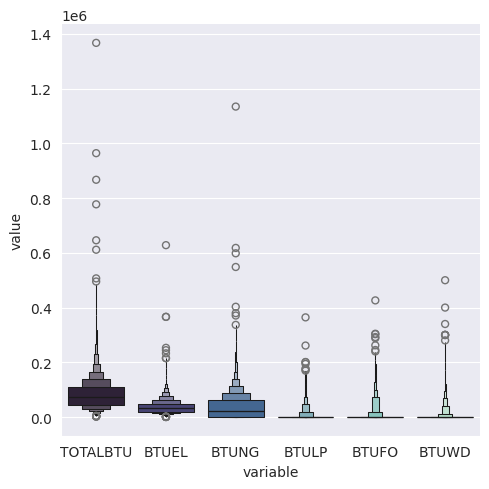

In [5]:
target_vars = meta.query("`section` == 'End-use Model'")['variable'].tolist()

melted = households[target_vars].melt()
g = sns.catplot(data=melted, x='variable', y='value', hue='variable', legend=False, kind='boxen')
plt.show()

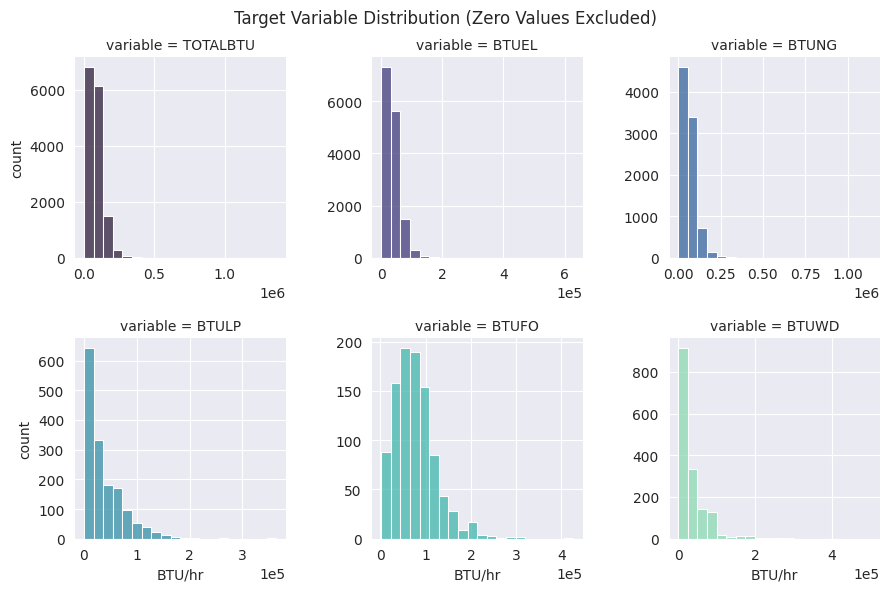

In [6]:
def plot_hist(cols, title, xlabel=None):
    melted = households[cols].melt()
    melted = melted[melted['value'] > 0]

    g = sns.FacetGrid(melted, col='variable', hue='variable', col_wrap=3, sharex=False, sharey=False)
    g.map(sns.histplot, 'value', bins=20)
    g.set_axis_labels(xlabel, 'count')
    g.fig.suptitle(title)
    g.fig.subplots_adjust(top=0.9, hspace=0.4)
    return g

g = plot_hist(target_vars, 'Target Variable Distribution (Zero Values Excluded)', 'BTU/hr')
for ax in g.axes.flat:
    ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.show()

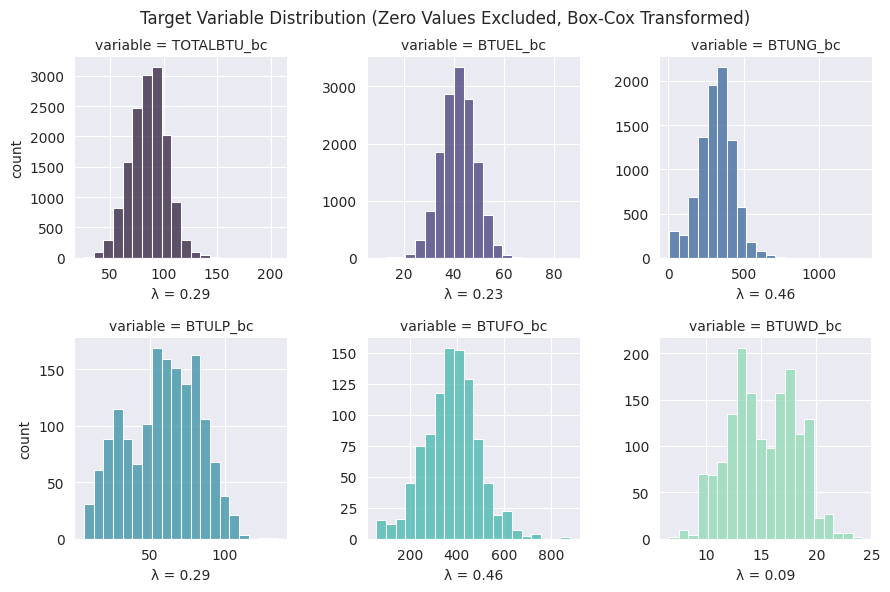

In [7]:
from scipy.stats import boxcox

for col in target_vars:
    non_zero_rows = households[col] > 0
    transformed, lmda = boxcox(households.loc[non_zero_rows, col])
    households.loc[non_zero_rows, f'{col}_bc'] = transformed
    households.loc[~non_zero_rows, f'{col}_bc'] = 0
    households[f'{col}_lambda'] = [lmda] * len(households)

target_vars_bc = [f'{col}_bc' for col in target_vars]

g = plot_hist(target_vars_bc, 'Target Variable Distribution (Zero Values Excluded, Box-Cox Transformed)', 'BTU/hr')
for (var, axes) in g.axes_dict.items():
    lmda = households[var.replace('_bc', '_lambda')].iloc[0]
    axes.set(xlabel=f'λ = {lmda:.2f}')
plt.show()

target_cols_transformed = [f'{col}_bc' for col in target_vars]

## Geographic variable analysis

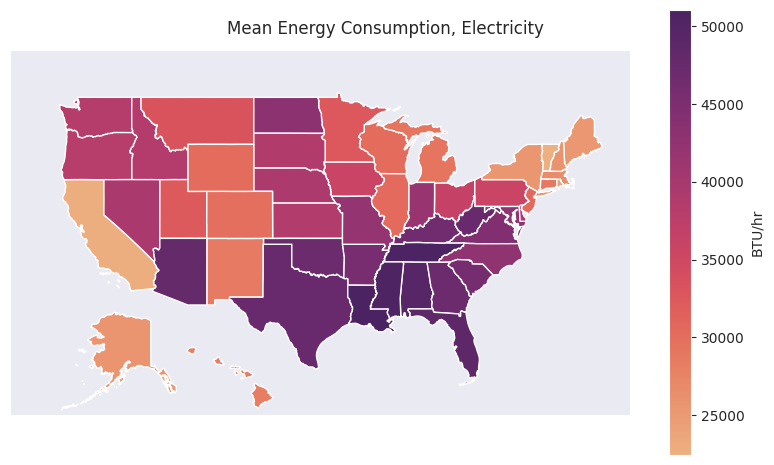

In [8]:
us_states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip')[['STUSPS', 'geometry']]
us_states.rename(columns={'STUSPS': 'state_postal'}, inplace=True)
us_states.set_index('state_postal', inplace=True)

def plot_geo(target_col, title, unit, palette='flare'):
    grouped = households.groupby('state_postal')[[target_col]].mean()
    grouped = us_states.merge(grouped, on='state_postal')

    fig, continental_ax = plt.subplots(figsize=(10, 5))
    alaska_ax = continental_ax.inset_axes([.08, .01, .20, .28])
    hawaii_ax = continental_ax.inset_axes([.28, .01, .15, .19])

    continental_ax.set_xlim(-130, -64)
    continental_ax.set_ylim(22, 53)

    alaska_ax.set_xlim(-180, -127)
    alaska_ax.set_ylim(51, 72)

    hawaii_ax.set_xlim(-160, -154.6)
    hawaii_ax.set_ylim(18.8, 22.5)

    vmin, vmax = grouped[target_col].agg(['min', 'max'])
    grouped.drop(index=['HI', 'AK']).plot(
        column=target_col,
        ax=continental_ax,
        vmin=vmin,
        vmax=vmax,
        legend=True,
        legend_kwds={'label': unit},
        cmap=sns.color_palette(palette, as_cmap=True),
    )
    grouped.loc[['AK']].plot(
        column=target_col,
        cmap=sns.color_palette(palette, as_cmap=True),
        ax=alaska_ax,
        vmin=vmin,
        vmax=vmax
    )
    grouped.loc[['HI']].plot(
        column=target_col,
        cmap=sns.color_palette(palette, as_cmap=True),
        ax=hawaii_ax,
        vmin=vmin,
        vmax=vmax
    )

    continental_ax.set_xticks([])
    continental_ax.set_yticks([])

    for ax in [alaska_ax, hawaii_ax]:
        ax.axis('off')
    
    fig.suptitle(title)
    fig.subplots_adjust(top=1)
    plt.show()

plot_geo('BTUEL', 'Mean Energy Consumption, Electricity', 'BTU/hr')

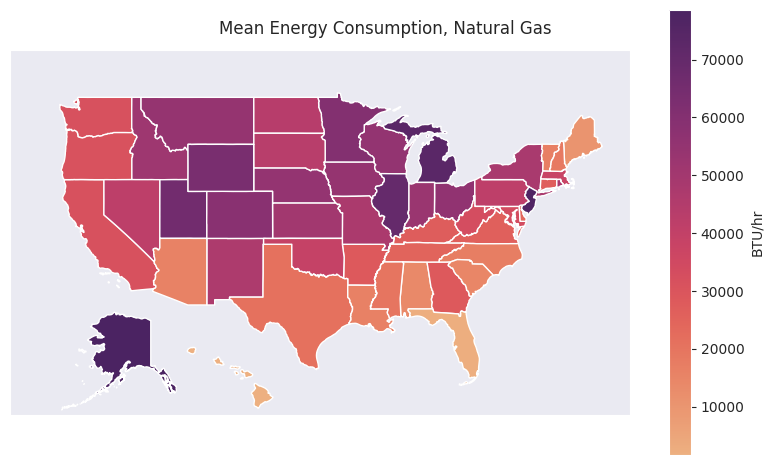

In [9]:
plot_geo('BTUNG', 'Mean Energy Consumption, Natural Gas', 'BTU/hr')

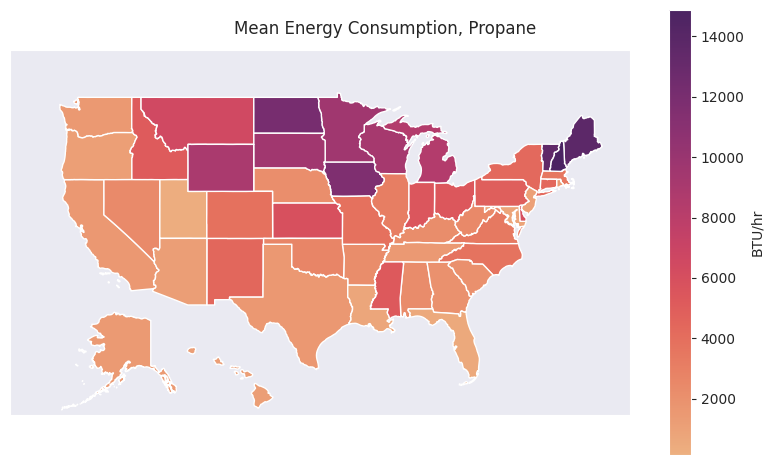

In [10]:
plot_geo('BTULP', 'Mean Energy Consumption, Propane', 'BTU/hr')

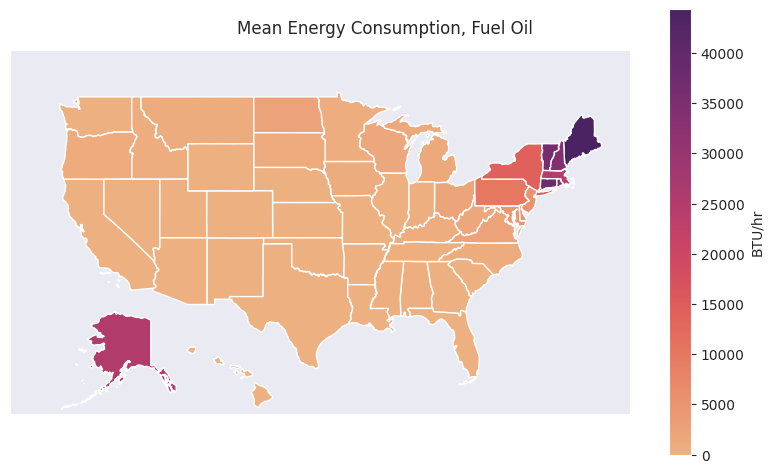

In [11]:
plot_geo('BTUFO', 'Mean Energy Consumption, Fuel Oil', 'BTU/hr')

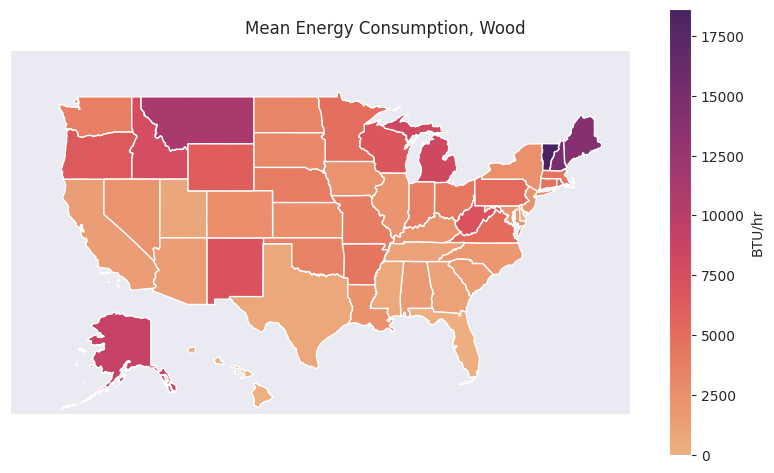

In [12]:
plot_geo('BTUWD', 'Mean Energy Consumption, Wood', 'BTU/hr')

## Climate variable analysis

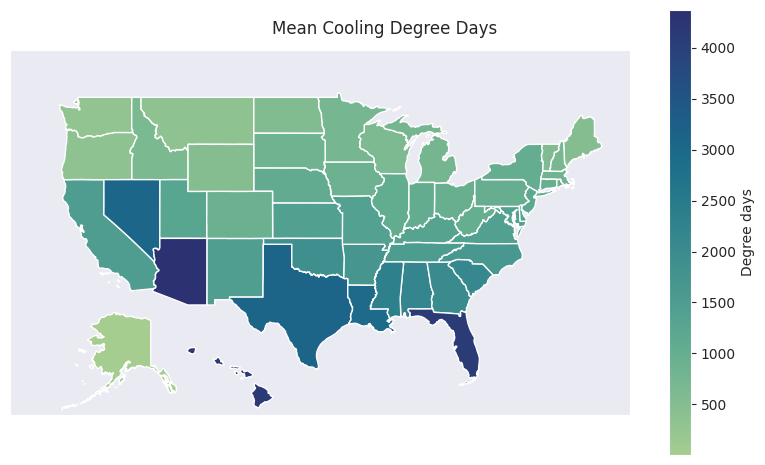

In [13]:
plot_geo('CDD65', 'Mean Cooling Degree Days', 'Degree days', 'crest')

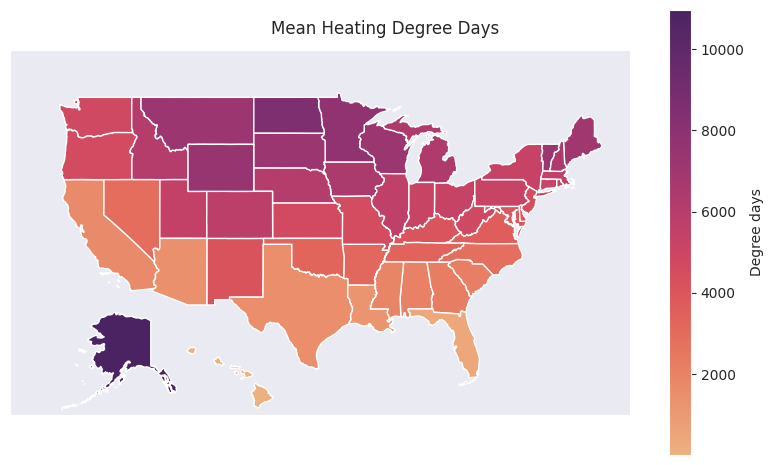

In [14]:
plot_geo('HDD65', 'Mean Heating Degree Days', 'Degree days')

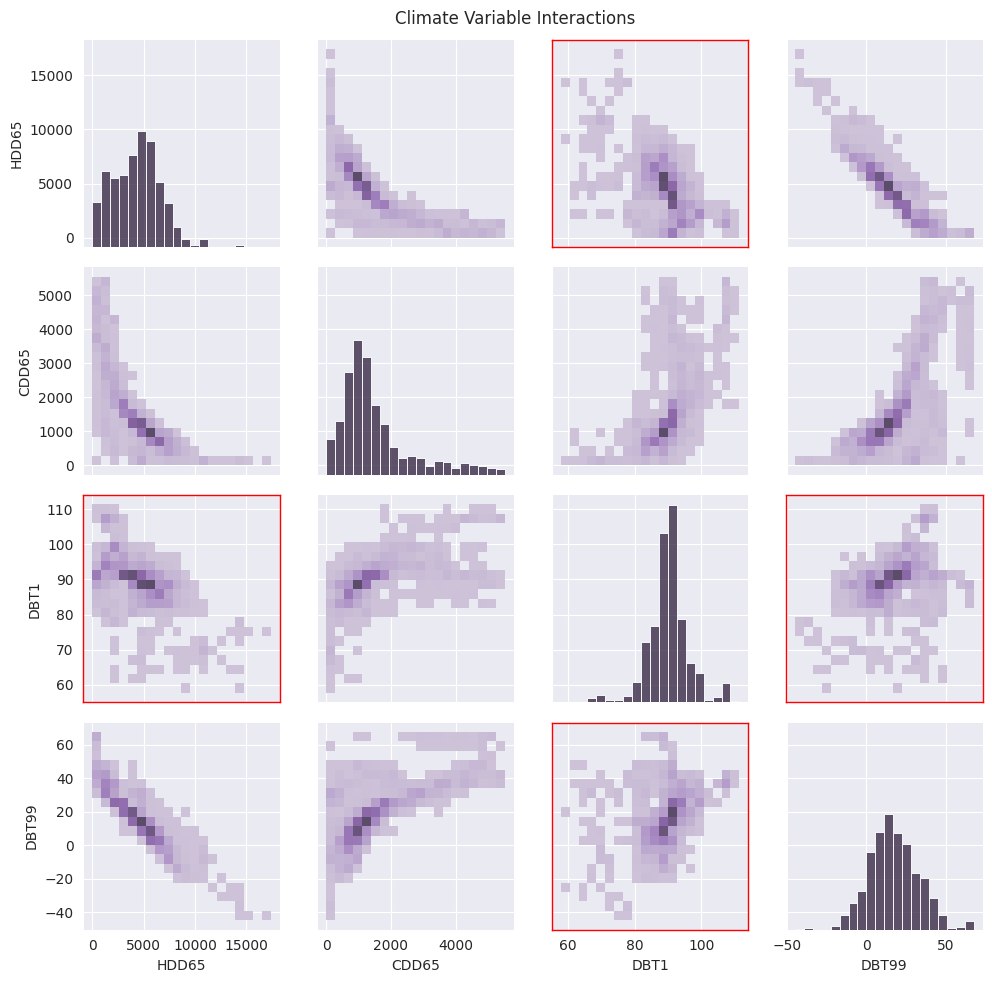

In [15]:
# HDD65, CDD65, DBT1, & DBT99 can all be inferred from the open-meteo API
weather_vars = meta.query("`section` == 'WEATHER'")['variable'].tolist()
weather_vars = [var for var in weather_vars if var not in ['HDD30YR_PUB', 'CDD30YR_PUB', 'GWT']]

# plot climate variable interactions
g = sns.PairGrid(data=households, vars=weather_vars)
g.map_diag(sns.histplot, bins=20)
g.map_offdiag(sns.histplot, bins=20)
g.fig.suptitle('Climate Variable Interactions')
g.fig.subplots_adjust(top=0.95)

# highlight that DBT1 is the only variable with visibly weak correlations to its neighbors:
for i, j in [(0, 2), (2, 0), (2, 3), (3, 2)]:
    ax = g.axes[i, j]
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('red')
        spine.set_linewidth(1)

plt.show()

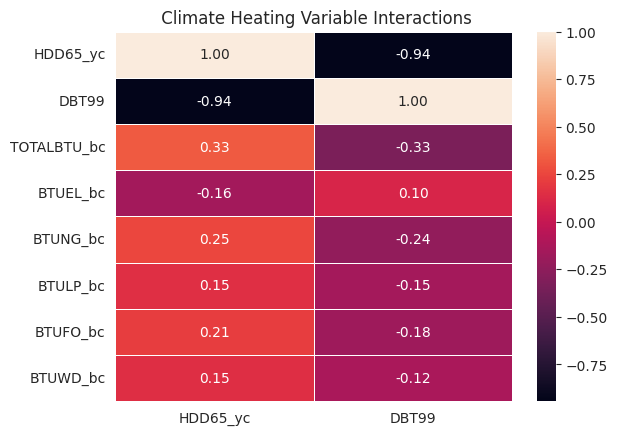

In [16]:
from scipy.stats import yeojohnson

# transform long-tailed degree-day variables
for col in ['CDD65', 'HDD65']:
    transformed, lmda = yeojohnson(households[col])
    households[f'{col}_yc'] = transformed
    households[f'{col}_lambda'] = [lmda] * len(households)

def plot_weather_corr(cols, title):
    corr = households[cols + target_vars_bc].corr()
    corr = corr[cols]

    ax = sns.heatmap(corr, annot=True, fmt='.2f', linewidth=0.5)
    ax.set_title(title)
    plt.show()

# plot heating climate features against targets
# note that heating design temperature is less correlated with heating degree days, and each interacts differently with targets
plot_weather_corr(['HDD65_yc', 'DBT99'],' Climate Heating Variable Interactions')

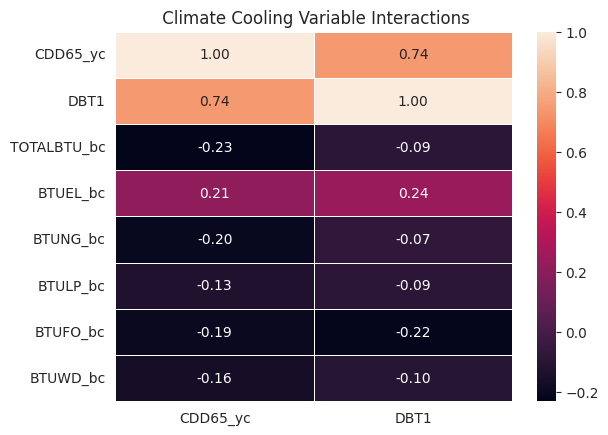

In [17]:
# plot cooling climate features against targets
# note that cooling design temperature is highly correlated with cooling degree days, and each have similar interactions with targets
plot_weather_corr(['CDD65_yc', 'DBT1'],' Climate Cooling Variable Interactions')

## Fuel variable analysis

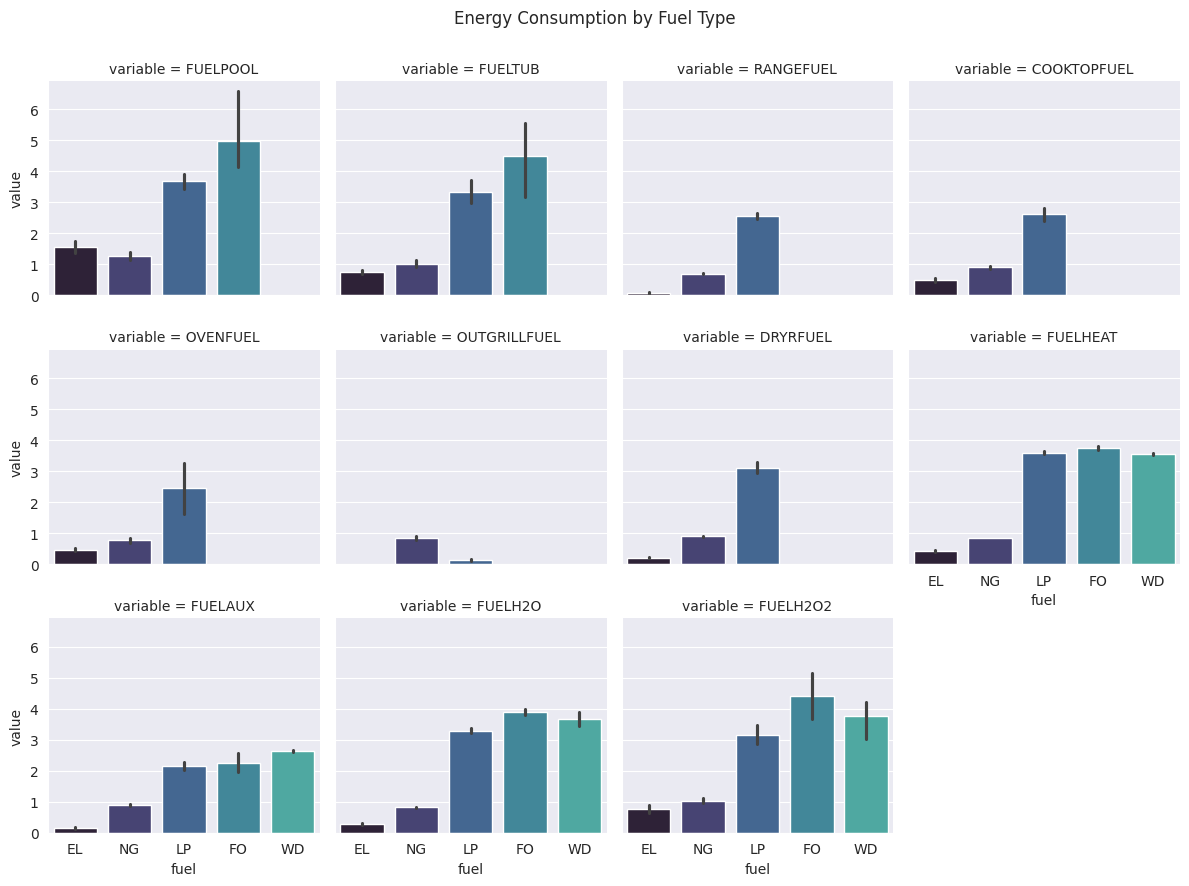

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

for col in target_vars:
    households[f'{col}_minmax'] = MinMaxScaler(feature_range=(-1, 1)).fit_transform(households[f'{col}_bc'].values.reshape(-1, 1))
    households[f'{col}_std'] = StandardScaler().fit_transform(households[f'{col}_bc'].values.reshape(-1, 1))

target_vars_minmax = [f'{col}_minmax' for col in target_vars]
target_vars_std = [f'{col}_std' for col in target_vars]

fuel_vars = ['FUELPOOL', 'FUELTUB', 'RANGEFUEL', 'COOKTOPFUEL', 'OVENFUEL', 'OUTGRILLFUEL', 'DRYRFUEL', 'FUELHEAT', 'FUELAUX', 'FUELH2O', 'FUELH2O2']

summary = pd.DataFrame(columns=['variable', 'fuel', 'value'])

for var in fuel_vars:
    melted = households.melt(id_vars=[var], value_vars=[v for v in target_vars_std if v != 'TOTALBTU_std'], var_name='fuel')
    melted[var] = melted[var].map({0: np.nan, 1: 'BTUNG_std', 2: 'BTULP_std', 3: 'BTUFO_std', 5: 'BTUEL_std', 7: 'BTUWD_std'}).dropna()
    melted = melted[melted[var] == melted['fuel']]
    melted = melted.drop(columns=[var])
    melted['fuel'] = melted['fuel'].map(lambda x: x[3:5])
    melted['variable'] = var
    summary = pd.concat([summary, melted], axis=0, ignore_index=True)

g = sns.catplot(data=summary, x='fuel', y='value', hue='fuel', col='variable', kind='bar', height=3, col_wrap=4, legend=False, sharex=True, sharey=True)
g.fig.suptitle(f'Energy Consumption by Fuel Type')
g.fig.subplots_adjust(top=0.9)
plt.show()

## Home variable analysis

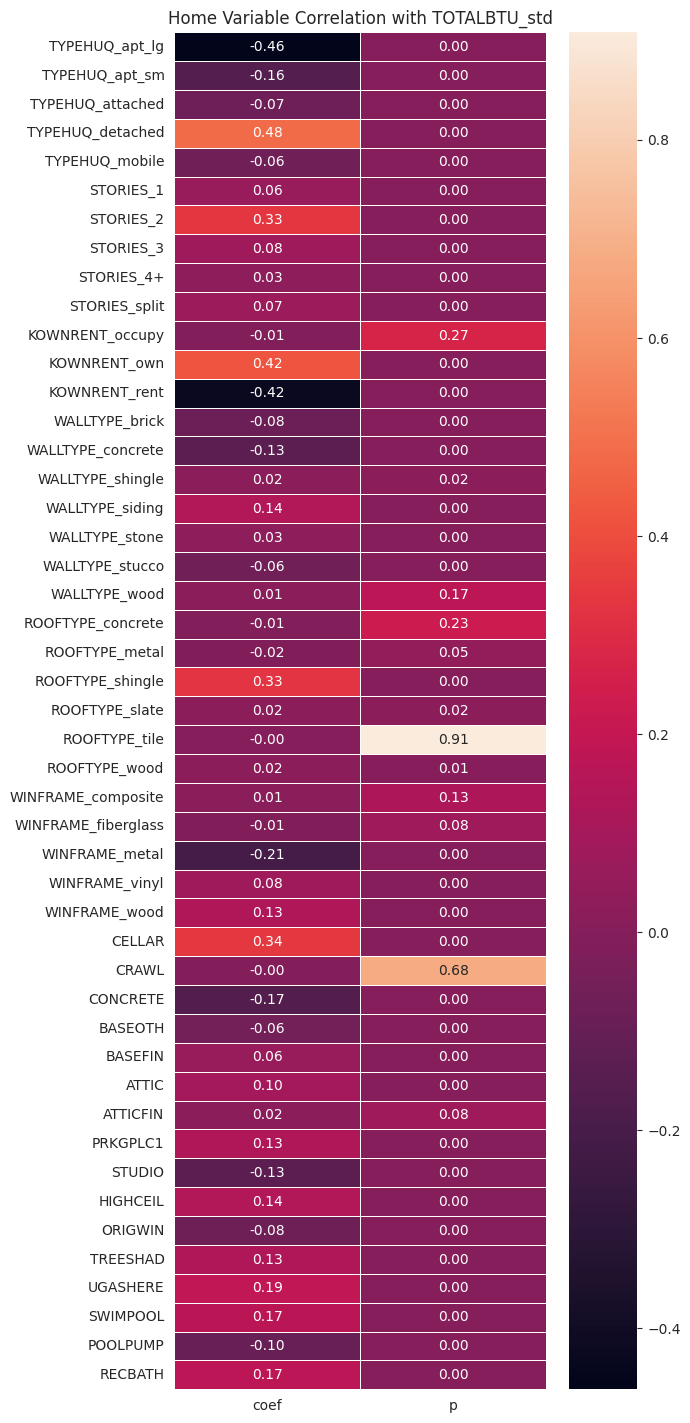

In [19]:
from scipy.stats import pointbiserialr

home_vars = meta.query("`section` == 'YOUR HOME'")['variable'].tolist()

home = households[home_vars + ['TOTALBTU_std']].copy().replace({
    'TYPEHUQ': {1: 'mobile', 2: 'detached', 3: 'attached', 4: 'apt_sm', 5: 'apt_lg'},
    'STORIES': {1: '1', 2: '2', 3: '3', 4: '4+', 5: 'split'},
    'KOWNRENT': {1: 'own', 2: 'rent', 3: 'occupy'},
    'WALLTYPE': {1: 'brick', 2: 'wood', 3: 'siding', 4: 'stucco', 5: 'shingle', 6: 'stone', 7: 'concrete', 99: np.nan},
    'ROOFTYPE': {1: 'tile', 2: 'wood', 3: 'metal', 4: 'slate', 5: 'shingle', 6: 'concrete', 99: np.nan},
    'WINFRAME': {1: 'wood', 2: 'metal', 3: 'vinyl', 4: 'composite', 5: 'fiberglass'},
})

home_categorical = [c for c in home_vars if c in categorical_vars and c not in fuel_vars]
home_boolean = [c for c in home_vars if c in boolean_vars and c not in ['SQFTINCB', 'SQFTINCA', 'SQFTINCG']]

to_corr = pd.concat([pd.get_dummies(home[home_categorical]), home[home_boolean]], axis=1)
corr = to_corr.corrwith(home['TOTALBTU_std'], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt='.2f', linewidth=0.5)
ax.set_xticklabels(['coef', 'p'])
ax.set_title('Home Variable Correlation with TOTALBTU_std')
plt.show()

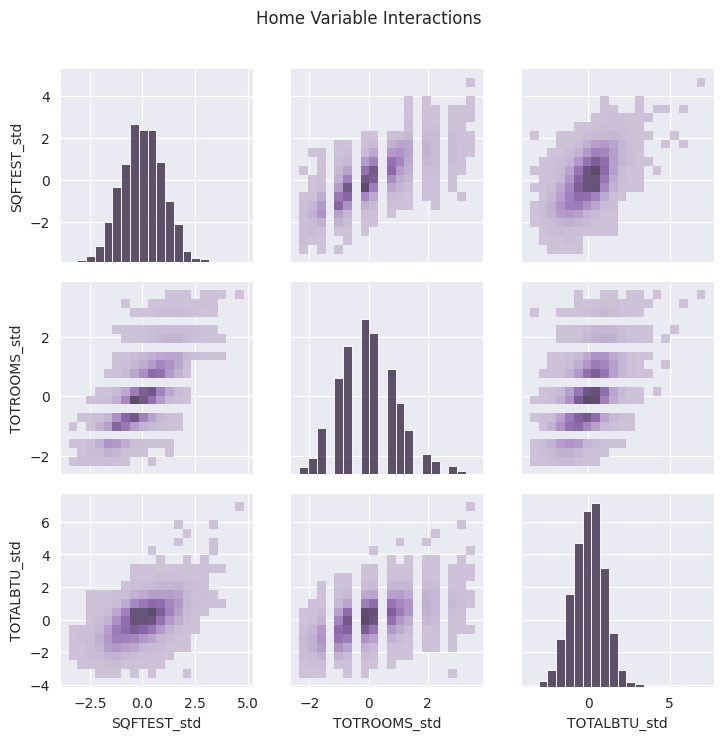

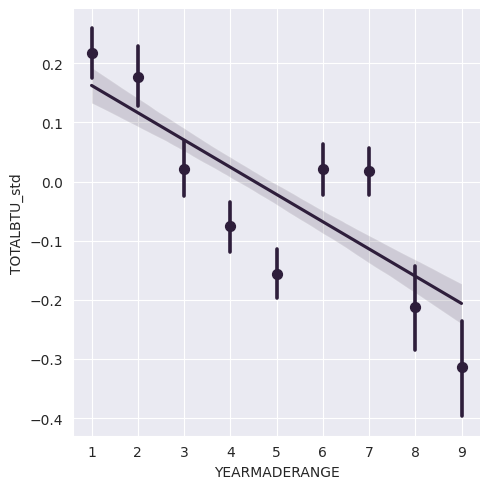

In [20]:
transformed, lmda = boxcox(home['SQFTEST'])
home['SQFTEST_bc'] = transformed
home['SQFTEST_lambda'] = [lmda] * len(home)
home['SQFTEST_std'] = StandardScaler().fit_transform(home['SQFTEST_bc'].values.reshape(-1, 1))
home['TOTROOMS_std'] = StandardScaler().fit_transform(home['TOTROOMS'].values.reshape(-1, 1))

g = sns.PairGrid(data=home, vars=['SQFTEST_std', 'TOTROOMS_std', 'TOTALBTU_std'])
g.map_diag(sns.histplot, bins=20)
g.map_offdiag(sns.histplot, bins=20)
g.fig.suptitle('Home Variable Interactions')
g.fig.subplots_adjust(top=0.9)
plt.show()

sns.lmplot(data=home, x='YEARMADERANGE', y='TOTALBTU_std', x_estimator=np.mean)
plt.show()

## Appliance variable analysis

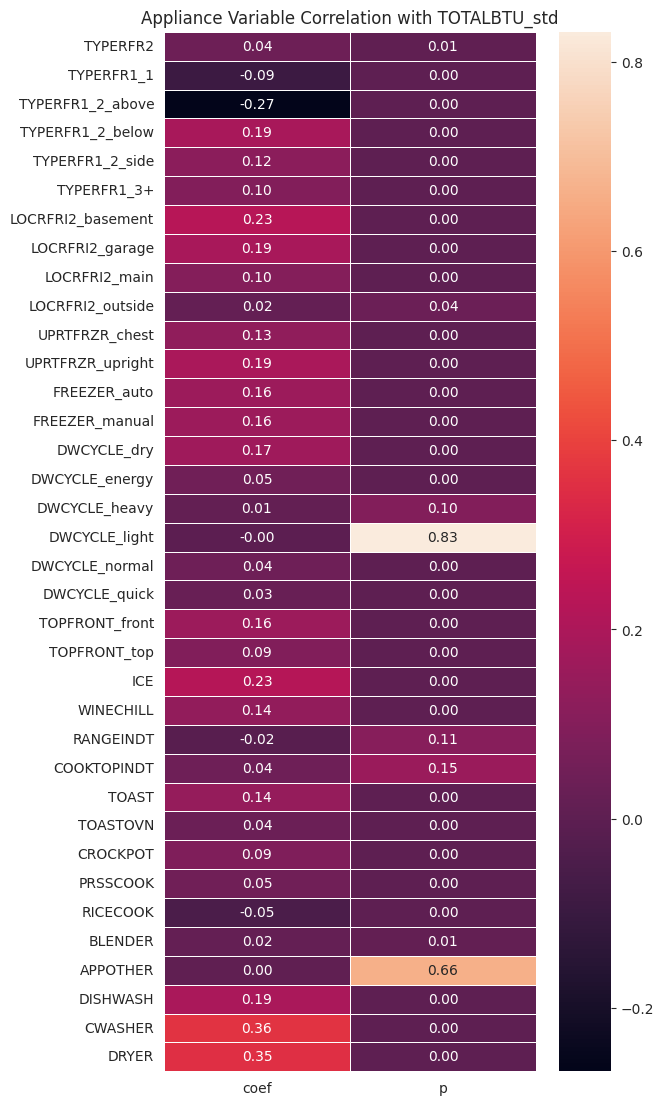

In [21]:
appliance_vars = meta.query("`section` == 'APPLIANCES'")['variable'].tolist()

appliances = households[appliance_vars + ['TOTALBTU_std']].copy().replace({
    'TYPERFR1': {1: '1', 2: '2_side', 3: '2_above', 4: '2_below', 5: '3+'},
    'TYPEFR2': {1: '1', 2: '2_side', 3: '2_above', 4: '2_below', 5: '3+'},
    'LOCRFRI2': {1: 'basement', 2: 'garage', 3: 'outside', 4: 'main', 99: np.nan},
    'UPRTFRZR': {1: 'upright', 2: 'chest'},
    'FREEZER': {1: 'manual', 2: 'auto'},
    'NUMMEAL': {0: 7},
    'USECOFFEE': {0: 3},
    'DWCYCLE': {1: 'normal', 2: 'dry', 3: 'heavy', 4: 'light', 5: 'energy', 6: 'quick'},
    'TOPFRONT': {1: 'top', 2: 'front'},
    'WASHTEMP': {np.nan: 4},
})

appliances_categorical = [c for c in appliance_vars if c in categorical_vars and c not in fuel_vars]
appliances_boolean = [c for c in appliance_vars if c in boolean_vars and c not in ['OUTGRILL', 'ELFOOD', 'LPCOOK', 'UGCOOK']]

to_corr = pd.concat([pd.get_dummies(appliances[appliances_categorical]), appliances[appliances_boolean]], axis=1)
corr = to_corr.corrwith(appliances['TOTALBTU_std'], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt='.2f', linewidth=0.5)
ax.set_xticklabels(['coef', 'p'])
ax.set_title('Appliance Variable Correlation with TOTALBTU_std')
plt.show()

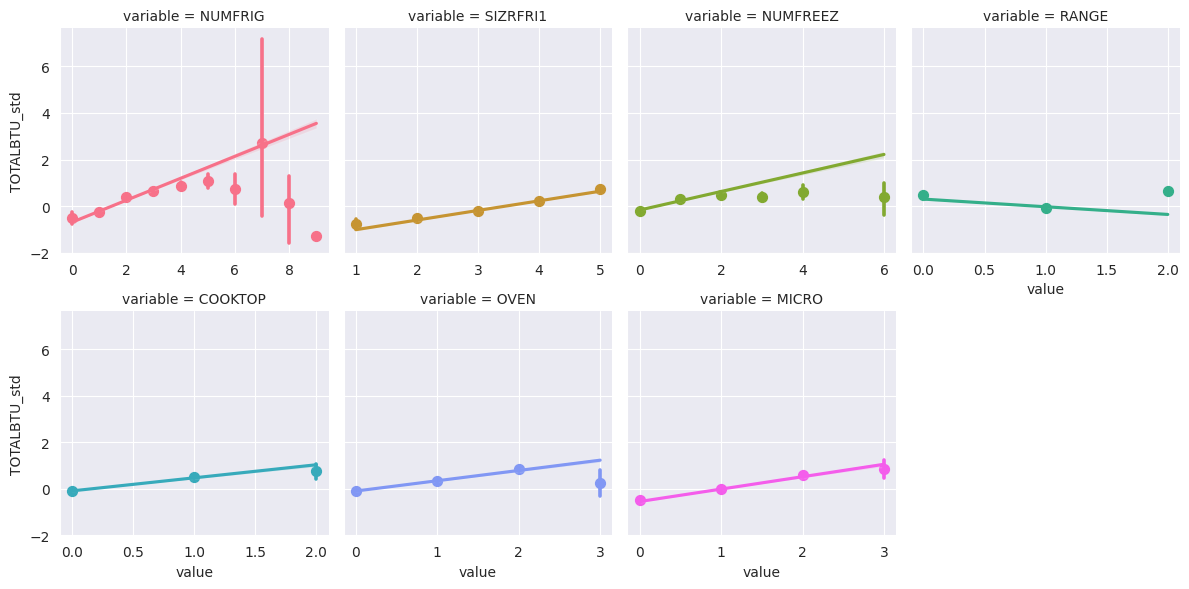

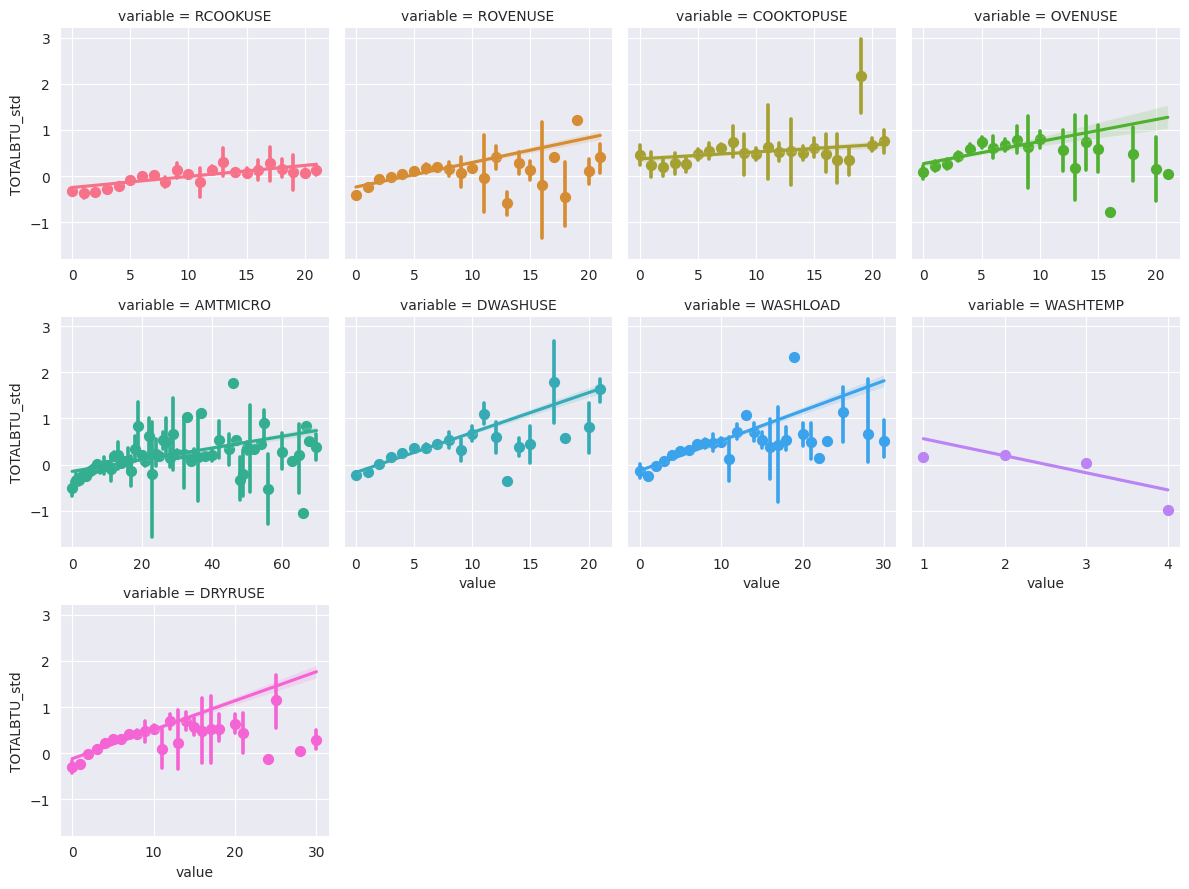

In [22]:
appliances_numerical = [c for c in appliance_vars if c in numerical_vars]
appliances_ordinal = [c for c in appliance_vars if c in ordinal_vars] 

melted = appliances.melt(id_vars=['TOTALBTU_std'], value_vars=['NUMFRIG', 'SIZRFRI1', 'NUMFREEZ', 'RANGE', 'COOKTOP', 'OVEN', 'MICRO'])
sns.lmplot(data=melted, x='value', y='TOTALBTU_std', col='variable', hue='variable', x_estimator=np.mean, legend=False, height=3, col_wrap=4, facet_kws={'sharex': False})
plt.show()

melted = appliances.melt(id_vars=['TOTALBTU_std'], value_vars=['RCOOKUSE', 'ROVENUSE', 'COOKTOPUSE', 'OVENUSE', 'AMTMICRO', 'DWASHUSE', 'WASHLOAD','WASHTEMP', 'DRYRUSE'])
sns.lmplot(data=melted, x='value', y='TOTALBTU_std', col='variable', hue='variable', x_estimator=np.mean, legend=False, height=3, col_wrap=4, facet_kws={'sharex': False})
plt.show()

## Air conditioning variable analysis

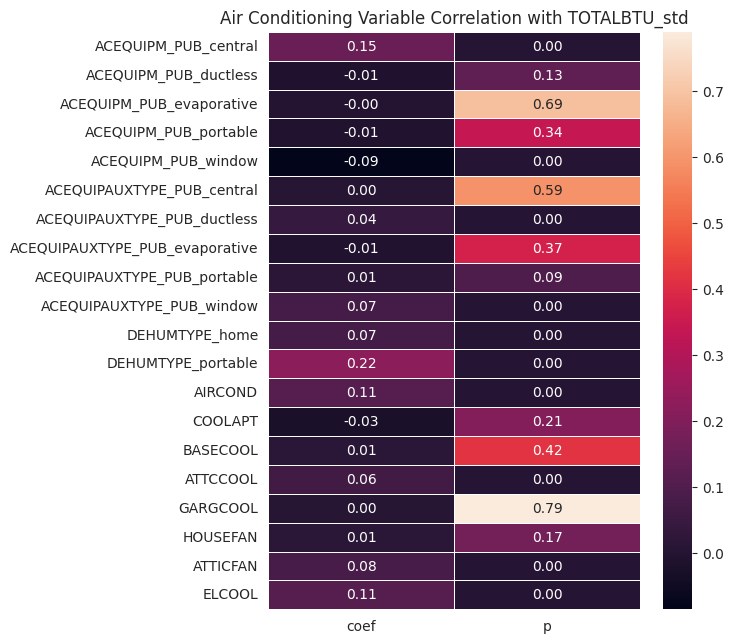

In [23]:
ac_vars = meta.query("`section` == 'AIR CONDITIONING'")['variable'].tolist()

ac = households[ac_vars + ['TOTALBTU_std']].copy().replace({
    'ACEQUIPM_PUB': {1: 'central', 3: 'ductless', 4: 'window', 5: 'portable', 6: 'evaporative'},
    'ACEQUIPAUXTYPE_PUB': {0: np.nan, 1: 'central', 3: 'ductless', 4: 'window', 5: 'portable', 6: 'evaporative'},
    'USECFAN': {99: np.nan},
    'DEHUMTYPE': {0: np.nan, 1: 'portable', 2: 'home'},
    'USEDEHUM': {99: np.nan},
})

ac_categorical = [c for c in ac_vars if c in categorical_vars]
ac_boolean = [c for c in ac_vars if c in boolean_vars]

to_corr = pd.concat([pd.get_dummies(ac[ac_categorical]), ac[ac_boolean]], axis=1)
corr = to_corr.corrwith(ac['TOTALBTU_std'], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt='.2f', linewidth=0.5)
ax.set_xticklabels(['coef', 'p'])
ax.set_title('Air Conditioning Variable Correlation with TOTALBTU_std')
plt.show()

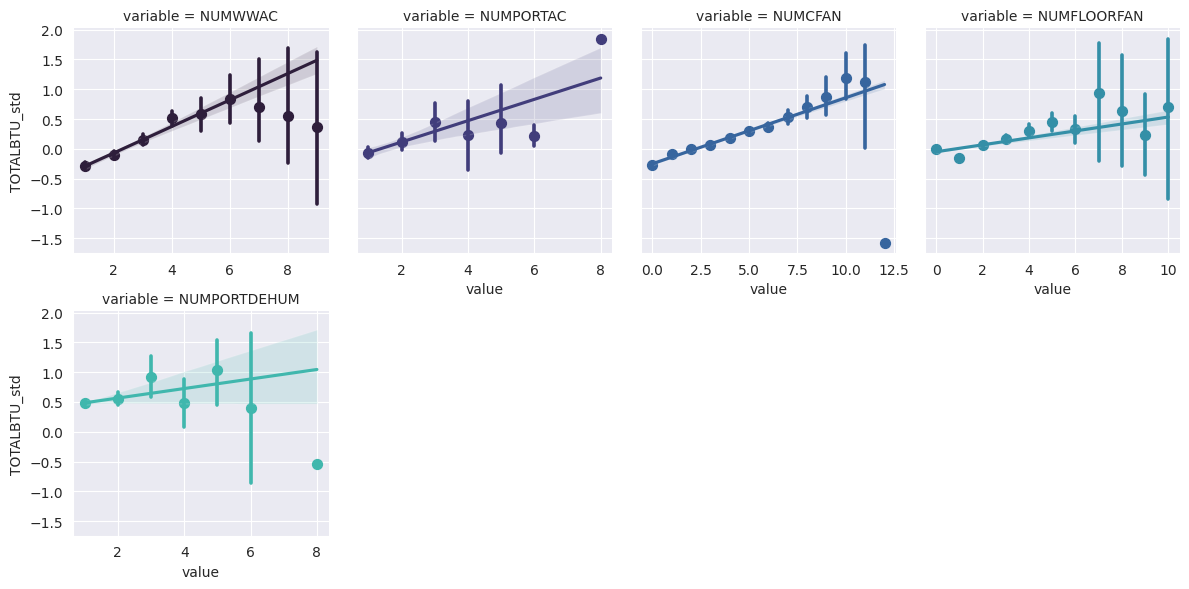

In [24]:
ac_numerical = [c for c in ac_vars if c in numerical_vars]
ac_ordinal = [c for c in ac_vars if c in ordinal_vars] 

melted = ac.melt(id_vars=['TOTALBTU_std'], value_vars=['NUMWWAC', 'NUMPORTAC', 'NUMCFAN', 'NUMFLOORFAN', 'NUMPORTDEHUM'])
sns.lmplot(data=melted, x='value', y='TOTALBTU_std', col='variable', hue='variable', x_estimator=np.mean, legend=False, height=3, col_wrap=4, facet_kws={'sharex': False})
plt.show()

## Heating variable analysis

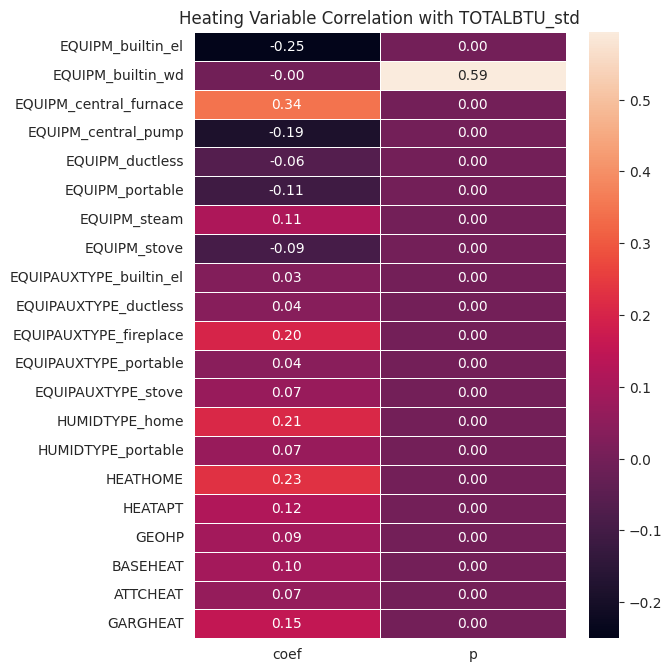

In [25]:
heating_vars = meta.query("`section` == 'SPACE HEATING'")['variable'].tolist()

heating = households[heating_vars + ['TOTALBTU_std']].copy().replace({
    'EQUIPM': {2: 'steam', 3: 'central_furnace', 4: 'central_pump', 5: 'builtin_el', 7: 'builtin_wd', 8: 'stove', 10: 'portable', 13: 'ductless', 99: np.nan},
    'EQUIPAUXTYPE': {0: np.nan, 5: 'builtin_el', 8: 'stove', 9: 'fireplace', 10: 'portable', 13: 'ductless', 99: np.nan},
    'HUMIDTYPE': {0: np.nan, 1: 'portable', 2: 'home'},
    'USEHUMID': {99: np.nan},
})

heating_categorical = [c for c in heating_vars if c in categorical_vars and c != 'DNTHEAT' and c not in fuel_vars]
heating_boolean = [c for c in heating_vars if c in boolean_vars and c not in ['EQUIPAUX', 'ELWARM', 'UGWARM', 'LPWARM', 'FOWARM', 'WDWARM']]

to_corr = pd.concat([pd.get_dummies(heating[heating_categorical]), heating[heating_boolean]], axis=1)
corr = to_corr.corrwith(heating['TOTALBTU_std'], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt='.2f', linewidth=0.5)
ax.set_xticklabels(['coef', 'p'])
ax.set_title('Heating Variable Correlation with TOTALBTU_std')
plt.show()

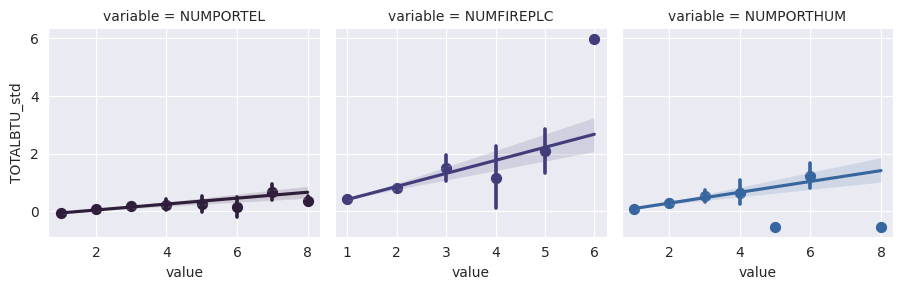

In [26]:
heating_numerical = [c for c in heating_vars if c in numerical_vars]
heating_ordinal = [c for c in heating_vars if c in ordinal_vars] 

melted = heating.melt(id_vars=['TOTALBTU_std'], value_vars=['NUMPORTEL', 'NUMFIREPLC', 'NUMPORTHUM'])
sns.lmplot(data=melted, x='value', y='TOTALBTU_std', col='variable', hue='variable', x_estimator=np.mean, legend=False, height=3, col_wrap=4, facet_kws={'sharex': False})
plt.show()

## Water heating variable analysis

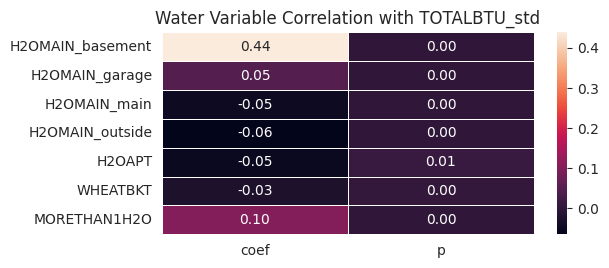

In [27]:
water_vars = meta.query("`section` == 'WATER HEATING'")['variable'].tolist()

water = households[water_vars + ['TOTALBTU_std']].copy().replace({
    'H2OMAIN': {1: 'main', 2: 'basement', 3: 'garage', 4: 'outside', 99: np.nan},
})

water_categorical = [c for c in water_vars if c in categorical_vars and c not in fuel_vars]
water_boolean = [c for c in water_vars if c in boolean_vars and c not in ['ELWATER', 'FOWATER', 'LPWATER', 'SOLWATER', 'WDWATER', 'UGWATER']]

to_corr = pd.concat([pd.get_dummies(water[water_categorical]), water[water_boolean]], axis=1)
corr = to_corr.corrwith(water['TOTALBTU_std'], method=pointbiserialr)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt='.2f', linewidth=0.5)
ax.set_xticklabels(['coef', 'p'])
ax.set_title('Water Variable Correlation with TOTALBTU_std')
plt.show()

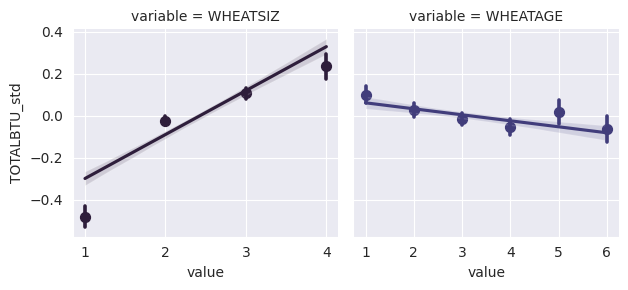

In [28]:
water_numerical = [c for c in water_vars if c in numerical_vars]
water_ordinal = [c for c in water_vars if c in ordinal_vars] 

melted = water.melt(id_vars=['TOTALBTU_std'], value_vars=water_numerical + water_ordinal)
sns.lmplot(data=melted, x='value', y='TOTALBTU_std', col='variable', hue='variable', x_estimator=np.mean, legend=False, height=3, col_wrap=4, facet_kws={'sharex': False})
plt.show()

## Electronics variable analysis

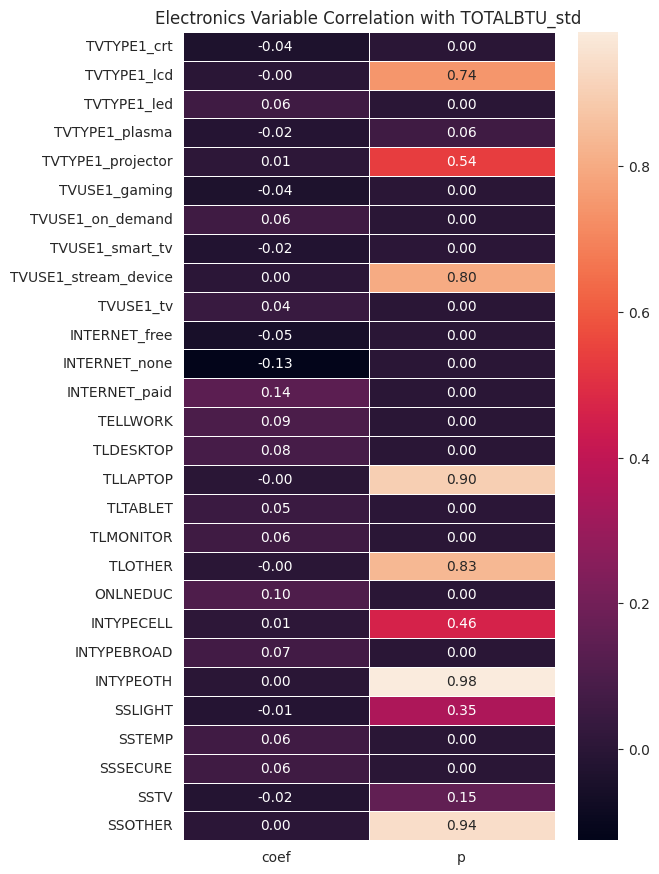

In [29]:
electronics_vars = meta.query("`section` == 'ELECTRONICS'")['variable'].tolist()

electronics = households[electronics_vars + ['TOTALBTU_std']].copy().replace({
    'TVTYPE1': {1: 'led', 2: 'lcd', 3: 'plasma', 4: 'projector', 5: 'crt'},
    'TVUSE1': {1: 'tv', 2: 'on_demand', 3: 'smart_tv', 4: 'stream_device', 5: 'gaming', 99: np.nan},
    'TVTYPE2': {1: 'led', 2: 'lcd', 3: 'plasma', 4: 'projector', 5: 'crt'},
    'TVUSE2': {1: 'tv', 2: 'on_demand', 3: 'smart_tv', 4: 'stream_device', 5: 'gaming', 99: np.nan},
    'TVTYPE3': {1: 'led', 2: 'lcd', 3: 'plasma', 4: 'projector', 5: 'crt'},
    'TVUSE3': {1: 'tv', 2: 'on_demand', 3: 'smart_tv', 4: 'stream_device', 5: 'gaming', 99: np.nan},
    'INTERNET': {0: 'none', 1: 'paid', 2: 'free'}
})

electronics_categorical = [c for c in electronics_vars if c in categorical_vars]
electronics_boolean = [c for c in electronics_vars if c in boolean_vars]

to_corr = pd.concat([pd.get_dummies(electronics[electronics_categorical]), electronics[electronics_boolean]], axis=1)
corr = to_corr.corrwith(electronics['TOTALBTU_std'], method=pointbiserialr)
corr.drop(list(corr.filter(regex='^TV.*(2|3)_')), axis=1, inplace=True)
plt.figure(figsize=(6, len(corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt='.2f', linewidth=0.5)
ax.set_xticklabels(['coef', 'p'])
ax.set_title('Electronics Variable Correlation with TOTALBTU_std')
plt.show()

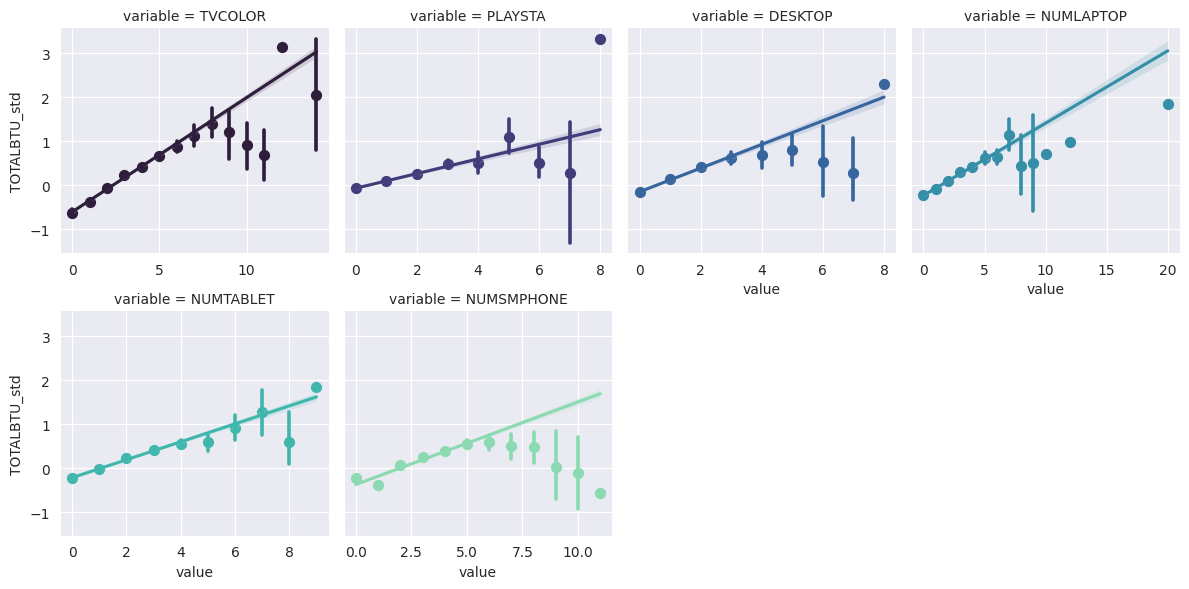

In [30]:
electronics_numerical = [c for c in electronics_vars if c in numerical_vars]
electronics_ordinal = [c for c in electronics_vars if c in ordinal_vars] 

melted = electronics.melt(id_vars=['TOTALBTU_std'], value_vars=['TVCOLOR', 'PLAYSTA', 'DESKTOP', 'NUMLAPTOP', 'NUMTABLET', 'NUMSMPHONE'])
sns.lmplot(data=melted, x='value', y='TOTALBTU_std', col='variable', hue='variable', x_estimator=np.mean, legend=False, height=3, col_wrap=4, facet_kws={'sharex': False})
plt.show()

## Household characteristics variable analysis

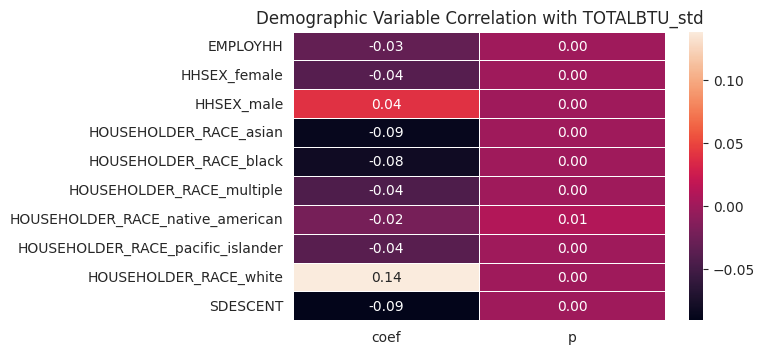

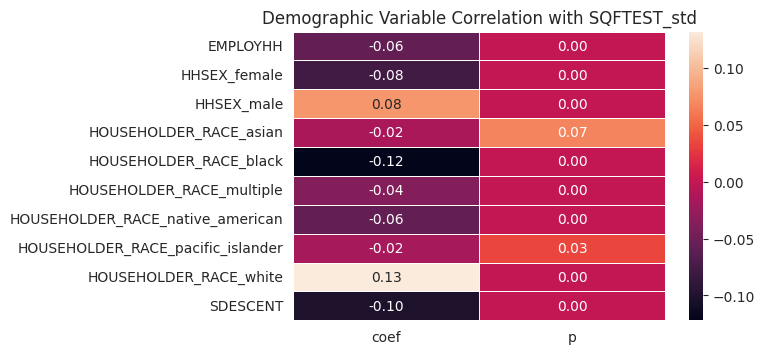

In [31]:
demo_vars = meta.query("`section` == 'HOUSEHOLD CHARACTERISTICS'")['variable'].tolist()

demo = households[demo_vars + ['SQFTEST', 'TOTALBTU_std']].copy().replace({
    'HHSEX': {1: 'female', 2: 'male'},
    'HOUSEHOLDER_RACE': {1: 'white', 2: 'black', 3: 'native_american', 4: 'asian', 5: 'pacific_islander', 6: 'multiple'},
})

demo_categorical = [c for c in demo_vars if c in categorical_vars]
demo_boolean = [c for c in demo_vars if c in boolean_vars]

to_corr = pd.concat([pd.get_dummies(demo[demo_categorical]), demo[demo_boolean]], axis=1)
corr = to_corr.corrwith(demo['TOTALBTU_std'], method=pointbiserialr)
plt.figure(figsize=(6, len(to_corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt='.2f', linewidth=0.5)
ax.set_xticklabels(['coef', 'p'])
ax.set_title('Demographic Variable Correlation with TOTALBTU_std')
plt.show()

transformed, lmda = boxcox(demo['SQFTEST'])
demo['SQFTEST_bc'] = transformed
demo['SQFTEST_lambda'] = [lmda] * len(home)
demo['SQFTEST_std'] = StandardScaler().fit_transform(demo['SQFTEST_bc'].values.reshape(-1, 1))

to_corr = pd.concat([pd.get_dummies(demo[demo_categorical]), demo[demo_boolean]], axis=1)
corr = to_corr.corrwith(demo['SQFTEST_std'], method=pointbiserialr)
plt.figure(figsize=(6, len(to_corr.columns) * 0.375))
ax = sns.heatmap(corr.T, annot=True, fmt='.2f', linewidth=0.5)
ax.set_xticklabels(['coef', 'p'])
ax.set_title('Demographic Variable Correlation with SQFTEST_std')
plt.show()

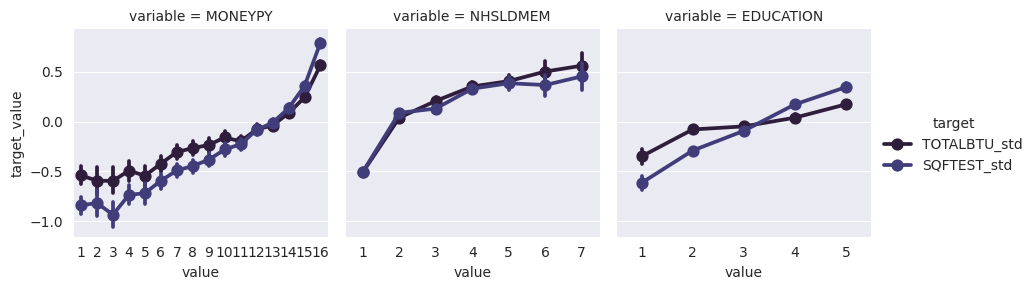

In [32]:
melted = demo.melt(id_vars=['TOTALBTU_std', 'SQFTEST_std'], value_vars=['MONEYPY', 'NHSLDMEM', 'EDUCATION'])
melted = melted.melt(id_vars=['variable', 'value'], value_vars=['TOTALBTU_std', 'SQFTEST_std'], var_name='target', value_name='target_value')
sns.catplot(data=melted, x='value', y='target_value', col='variable', hue='target', kind='point', height=3, legend=True, sharey=True, sharex=False)
plt.show()